# Preprocessing and clustering

In [1]:
# Core scverse libraries
import scanpy as sc
import anndata as ad

In [2]:
sc.settings.set_figure_params(dpi=77, facecolor="white")

In [3]:
samples = {
    "lung_raw": r"C:\Users\kssri\Downloads\GSE281744_RAW\Mus_musculus_lung_raw_feature_bc_matrix.h5",
    "lung_filtered": r"C:\Users\kssri\Downloads\GSE281744_RAW\Mus_musculus_lung_filtered_feature_bc_matrix.h5",
}

adatas = {}

for sample_id, filename in samples.items():
    path = (filename)
    sample_adata = sc.read_10x_h5(path)
    sample_adata.var_names_make_unique()
    adatas[sample_id] = sample_adata

adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\kssri\AppData\Local\Programs\Python\Python3

sample
lung_raw         2176391
lung_filtered      10205
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 2186596 × 32285
    obs: 'sample'

## Quality Control

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [5]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

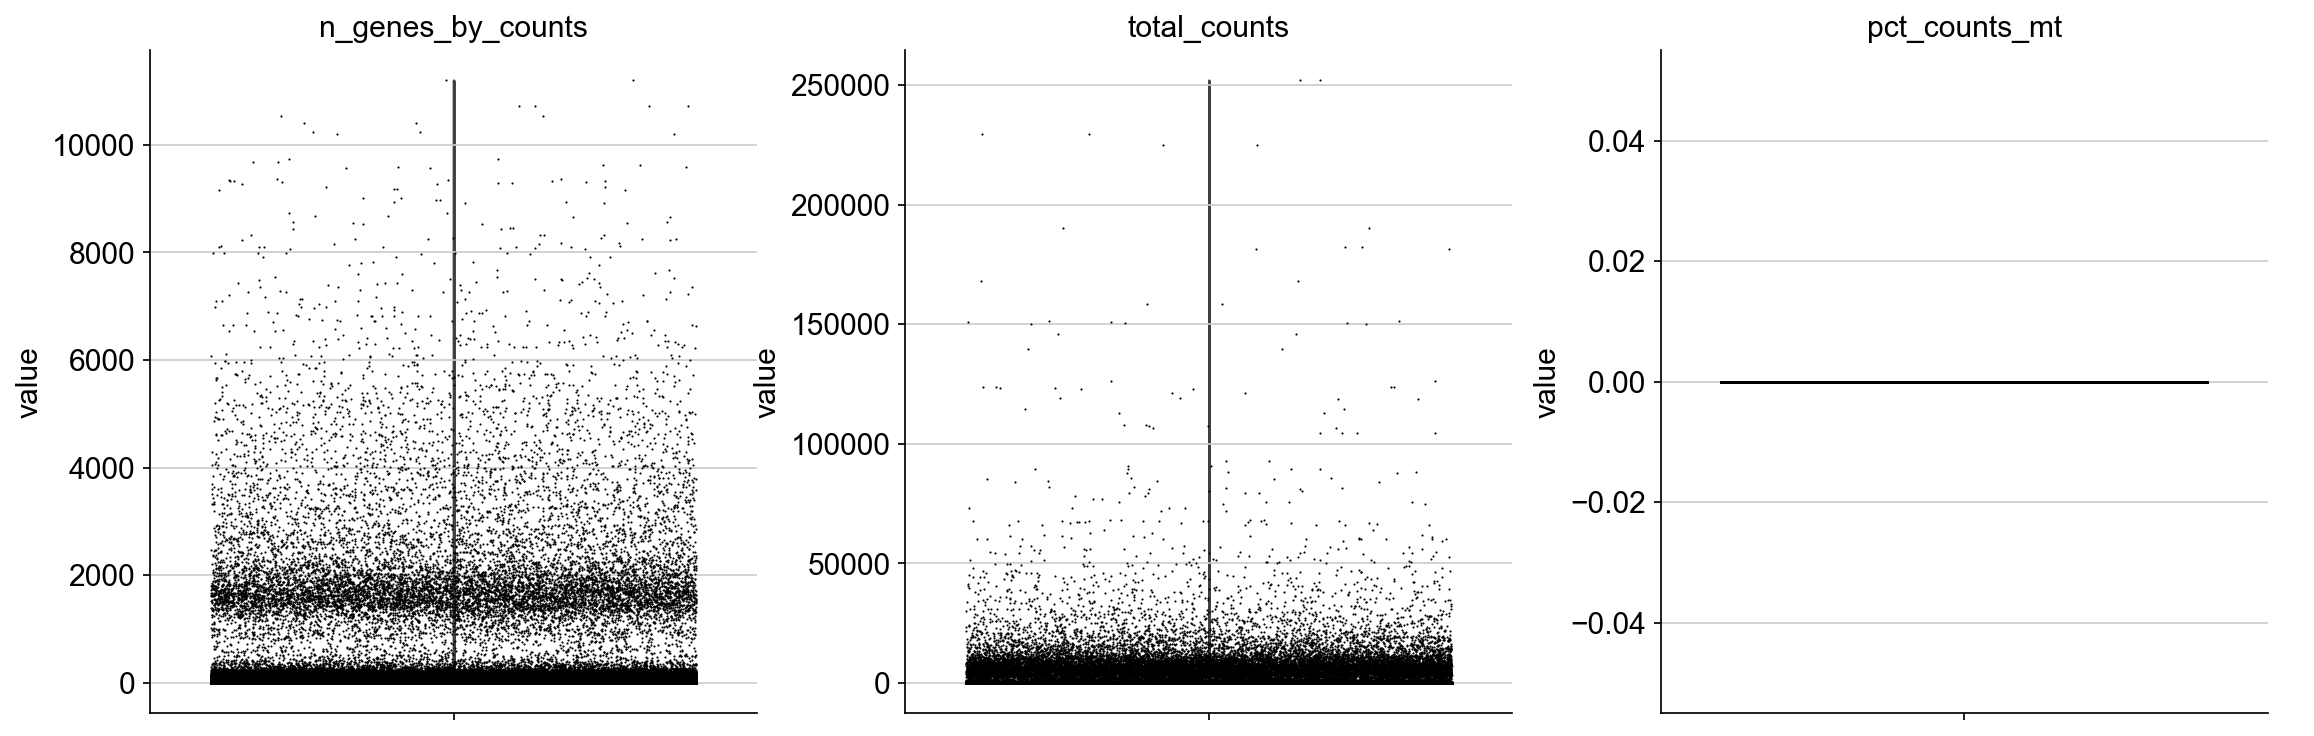

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

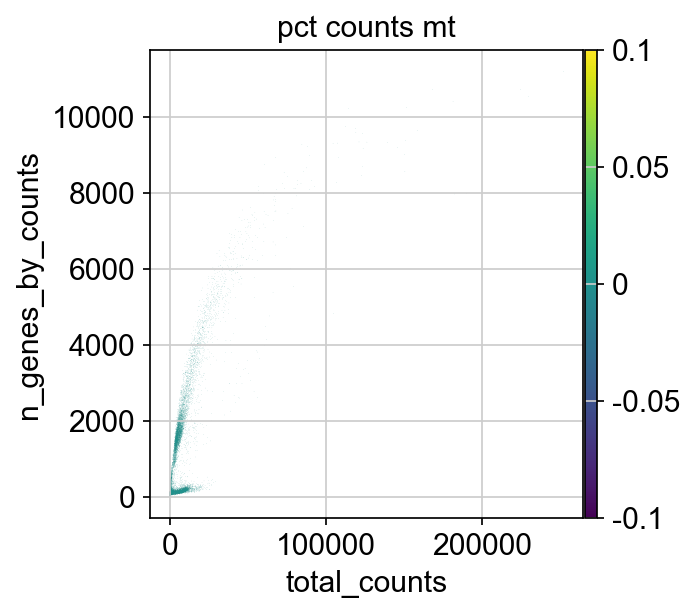

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [8]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

### Doublet detection

In [9]:
sc.pp.scrublet(adata, batch_key="sample") #, batch_key="sample"

C:\Users\kssri\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


## Normalization

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Feature selection

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")

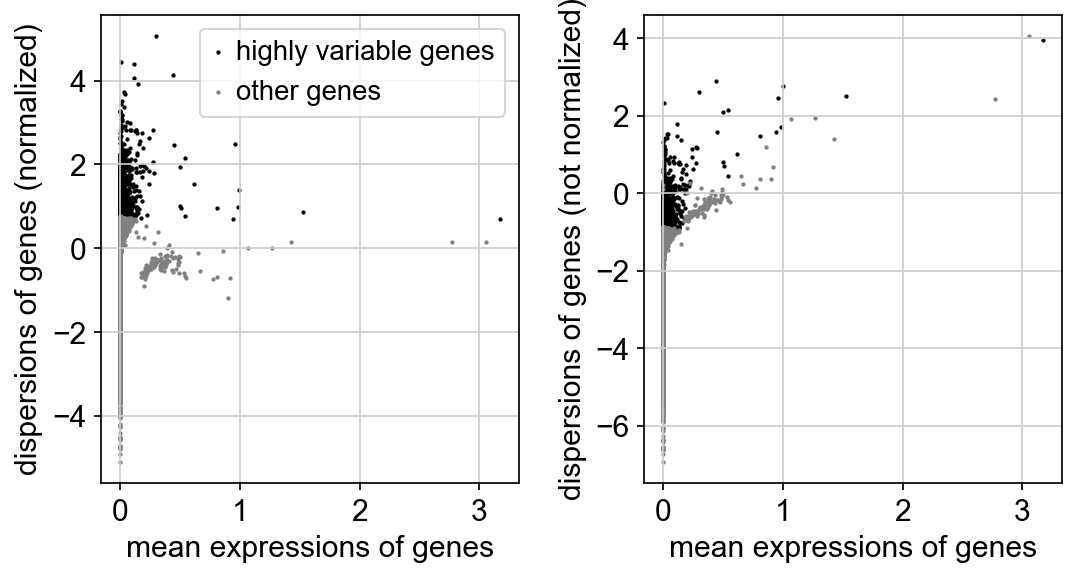

In [13]:
sc.pl.highly_variable_genes(adata)

## Dimensionality Reduction

In [14]:
sc.tl.pca(adata)

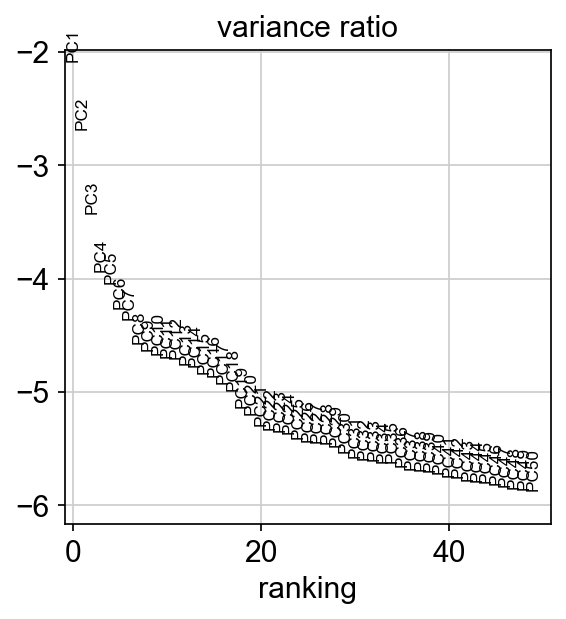

In [15]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

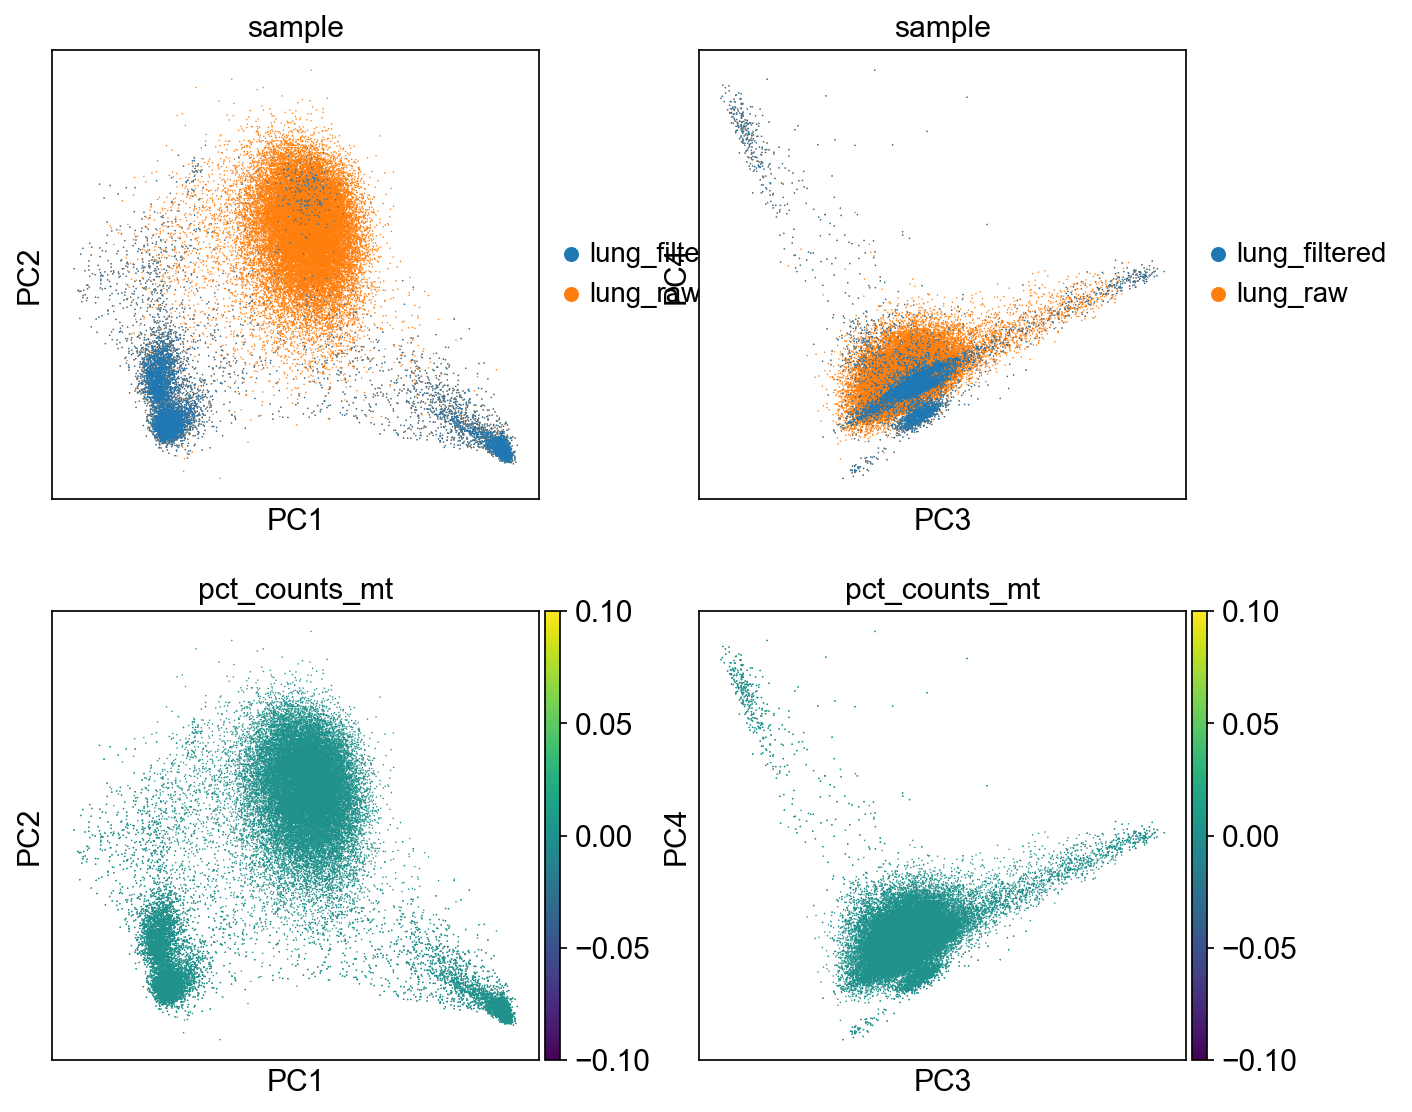

In [16]:
sc.pl.pca(
    adata,
    color=["sample", "sample", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
)

## Nearest neighbor graph constuction and visualization

In [17]:
sc.pp.neighbors(adata)

In [18]:
sc.tl.umap(adata)

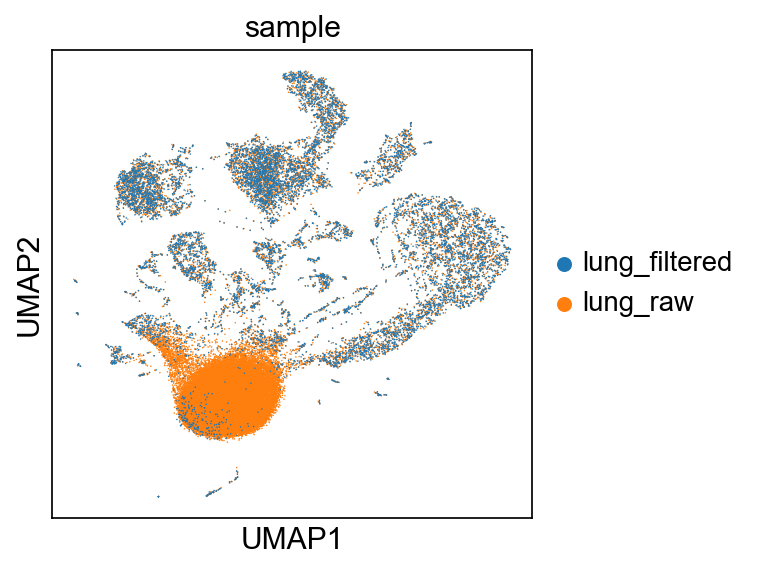

In [19]:
sc.pl.umap(
    adata,
    color="sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

## Clustering

In [20]:
# Calculate the percentage of mitochondrial counts per cell
adata.obs["pct_counts_mt"] = adata[:, adata.var["mt"]].X.sum(axis=1).A1 / adata.X.sum(axis=1).A1 * 100

In [21]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata)

C:\Users\kssri\AppData\Local\Temp\ipykernel_12228\859884257.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


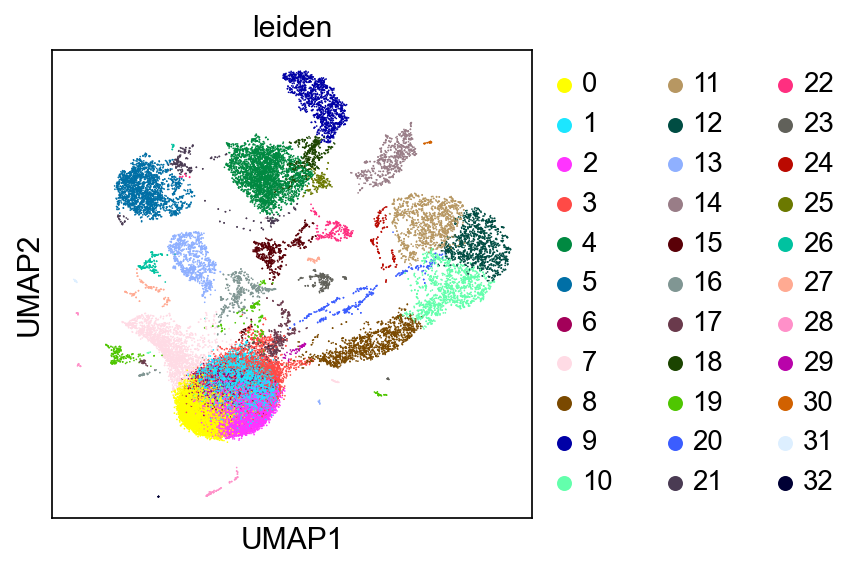

In [22]:
sc.pl.umap(adata, color=["leiden"])

## Re-assess quality control and cell filtering

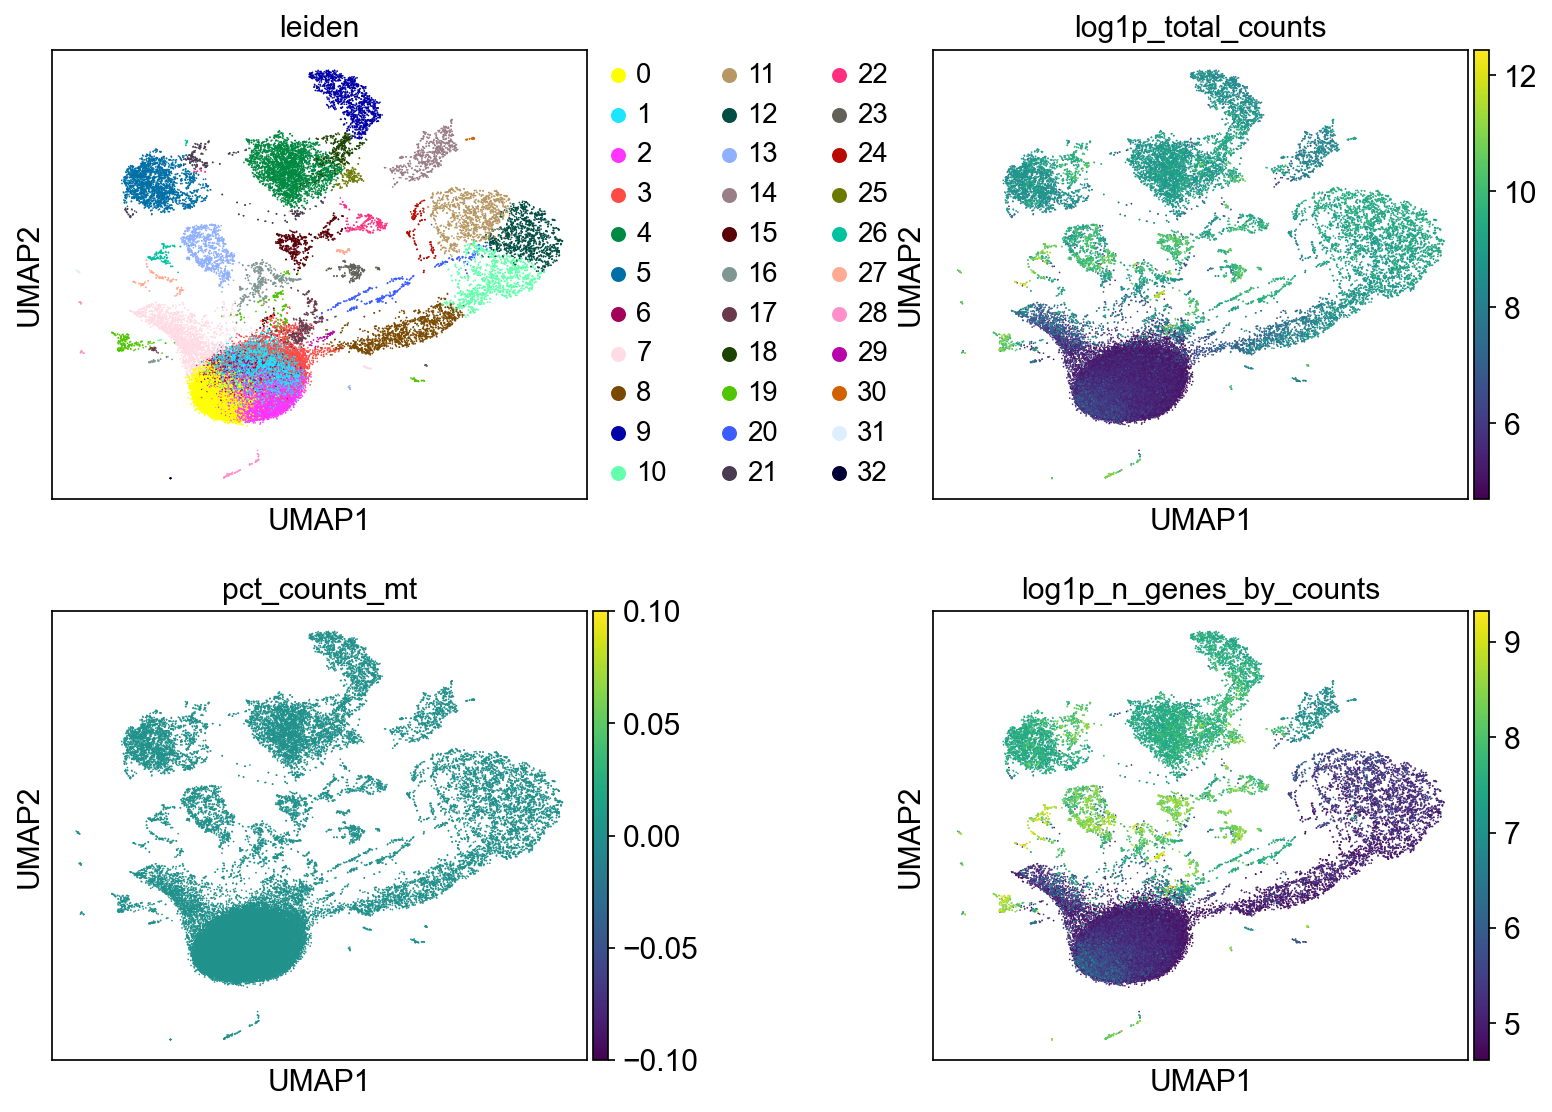

In [24]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)

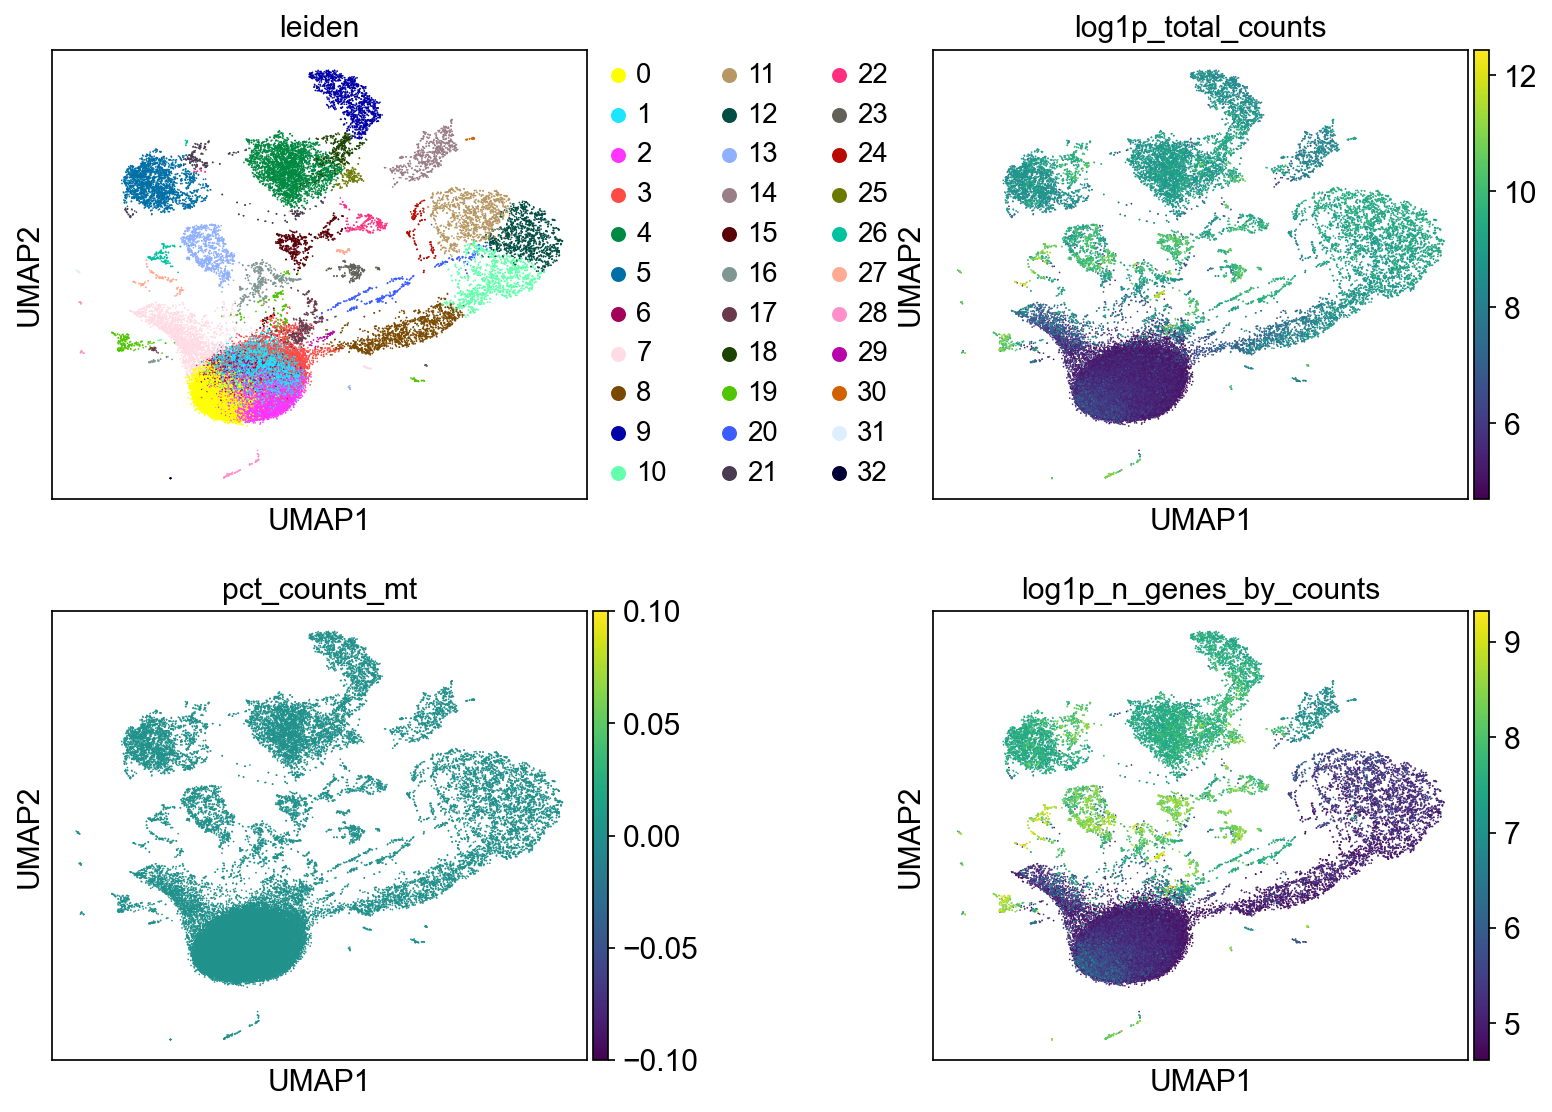

In [25]:
# Calculate the percentage of mitochondrial counts per cell
adata.obs["pct_counts_mt"] = adata[:, adata.var["mt"]].X.sum(axis=1).A1 / adata.X.sum(axis=1).A1 * 100
adata_mt = adata[:, adata.var["mt"]]
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
)